In [11]:
import pandas as pd

df_ben_ddos = pd.read_csv('df_ben_ddos.csv')
df_ben_ddos



,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,3232235972,48438,2300985238,23,1,5.030600,4,1,60,0,0,0
1,3232235972,33878,1352962162,23,1,3.089012,4,3,180,0,0,0
2,3232235972,55416,1539874379,23,1,3.089276,4,3,180,0,0,0
3,3232235972,47778,2258007740,23,1,5.030600,4,1,60,0,0,0
4,3232235972,46752,1732534418,23,1,3.130498,4,3,180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314090,3232235971,59699,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314091,3232235971,32909,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314092,3232235971,25120,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314093,3232235971,30340,2734184663,62336,1,5.030600,0,0,0,0,0,1


In [12]:
df_first = df_ben_ddos[:70000].sample(n=500, random_state=42)
df_last = df_ben_ddos[80000:].sample(n=500, random_state=42)
df_sampled = pd.concat([df_first, df_last], ignore_index=True)
df_sampled

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,3296074089,5151,2022758712,53,2,5.030600,4,1,540,0,0,0
1,3296074089,61215,820700452,53,2,5.030600,4,1,540,0,0,0
2,3296074089,60587,1658561341,53,2,5.030600,4,1,540,0,0,0
3,3232235972,52092,2210836888,23,1,3.119981,4,3,180,0,0,0
4,3296074089,5566,3818472118,53,2,5.030600,4,1,540,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,3232235972,56337,908547944,992,1,4.894192,3,5,200,0,0,1
996,3232235972,38377,908547944,992,1,2.417121,3,5,200,0,0,1
997,3232235972,9529,3512843912,22,1,5.030600,0,56,2800,0,0,1
998,3232235972,60214,908547944,992,1,3.827053,3,3,120,0,0,1


In [13]:
# Separate features and target labels
# X = df_sampled.drop(columns=['Category'])
X = df_sampled.drop(columns=['Category', 'id.resp_haddr', 'id.orig_addr'])
y = df_sampled['Category']
X

,id.orig_port,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes
0,5151,53,2,5.030600,4,1,540,0,0
1,61215,53,2,5.030600,4,1,540,0,0
2,60587,53,2,5.030600,4,1,540,0,0
3,52092,23,1,3.119981,4,3,180,0,0
4,5566,53,2,5.030600,4,1,540,0,0
...,...,...,...,...,...,...,...,...,...
995,56337,992,1,4.894192,3,5,200,0,0
996,38377,992,1,2.417121,3,5,200,0,0
997,9529,22,1,5.030600,0,56,2800,0,0
998,60214,992,1,3.827053,3,3,120,0,0


In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipaddress

# Assuming you have X (features) and y (target) already defined
# Example of X and y for illustration (replace with your actual dataset)
# X = pd.DataFrame(...)  # your feature DataFrame
# y = pd.Series(...)  # your target Series

# Initialize the outer cross-validation
outer_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Define parameter grid for Random Forest hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# List to hold the accuracy scores from the outer CV loop
outer_scores = []
best_model = None

# Outer cross-validation loop
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # Initialize Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # GridSearchCV for hyperparameter tuning within the inner CV loop
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    # Fit GridSearchCV on the training data of the current outer fold
    grid_search.fit(X_train, y_train)

    # Select the best model from the inner CV tuning
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the outer fold test set
    y_pred = best_model.predict(X_test)
    outer_accuracy = accuracy_score(y_test, y_pred)
    outer_scores.append(outer_accuracy)


    print(f"Best hyperparameters for this fold: {grid_search.best_params_}")
    print(f"Accuracy for this fold: {outer_accuracy}")

# Calculate and print the final results from the outer cross-validation loop
print("\nCross-validated outer accuracy scores:", outer_scores)
print("Mean accuracy:", np.mean(outer_scores))
print("Standard deviation of accuracy:", np.std(outer_scores))


# Train the model on the entire dataset
# best_model.fit(X, y)

csv_file = "flow.csv"
data = pd.read_csv(csv_file)
data

selected_features = ['sa', 'sp', 'td', 'ipkt', 'ibyt']
real = data[selected_features]
real.loc[:, 'sa'] = real['sa'].map(lambda ip: int(ipaddress.IPv4Address(ip)))
single_sample = real.iloc[0].values.reshape(1, -1)
print(single_sample)
best_model.predict(single_sample)


Best hyperparameters for this fold: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for this fold: 0.998
Best hyperparameters for this fold: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for this fold: 1.0

Cross-validated outer accuracy scores: [0.998, 1.0]
Mean accuracy: 0.999
Standard deviation of accuracy: 0.0010000000000000009
[[2521392202 3110 152.668 69 4623]]


ValueError: X has 5 features, but RandomForestClassifier is expecting 9 features as input.

id.orig_port 0.02350266941852173
id.resp_pport 0.4394417535826789
proto_enum 0.043364269637081995
duration_interval 0.041381929374776756
conn_state_string 0.3215588201019324
orig_pkts_count 0.07315337112664917
orig_ip_bytes_count 0.04910665809841488
resp_pkts_count 0.004493682725870802
resp_bytes 0.003996845934073476


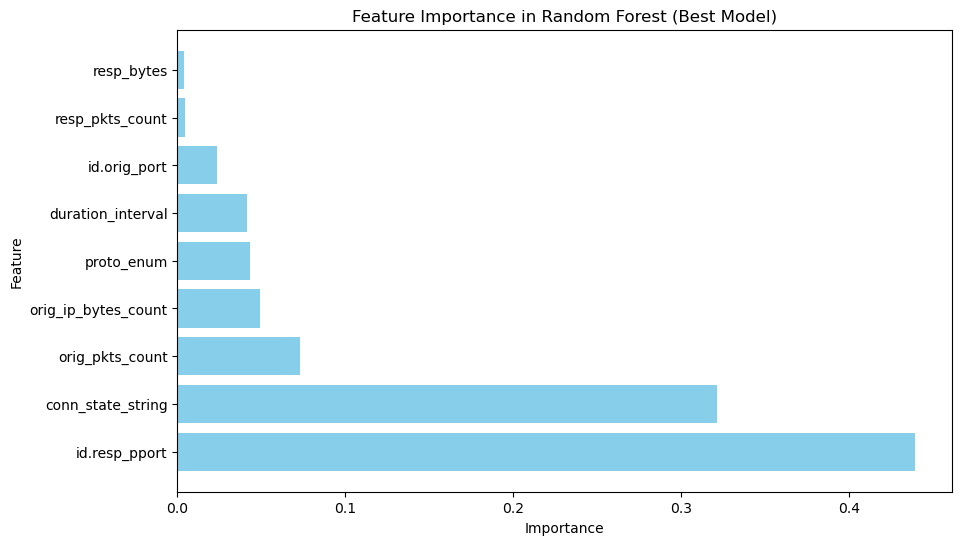

In [15]:
# After the outer CV loop, get the feature importance of the best model
importances = best_model.feature_importances_

# Create a DataFrame for easy plotting
feature_importances = pd.DataFrame({
    'feature': X.columns,  # assuming X is a DataFrame
    'importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

for i in range(len(feature_importances['feature'])):
    print(feature_importances['feature'][i], feature_importances['importance'][i])

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest (Best Model)')
plt.show()

In [18]:
import pandas as pd

# Load the CSV file
csv_file = "netflow_data.csv"
data = pd.read_csv(csv_file)  # Skip the first row if it contains metadata
data
# ['id.orig_addr','id.orig_port','id.resp_haddr','id.resp_pport','proto_enum','duration_interval','conn_state_string','orig_pkts_count','orig_ip_bytes_count','resp_pkts_count','resp_bytes', 'Category']
filtered_flows = data[data['da'] == '172.20.10.2']
selected_features = ['sp', 'dp', 'pr', 'td', 'flg', 'ibyt', 'ipkt', 'opkt', 'obyt']
filtered_flows = filtered_flows[selected_features]
filtered_flows['flg'] = filtered_flows['flg'].map(lambda flg: 4 if flg == '......S.' else flg)
filtered_flows['flg'] = filtered_flows['flg'].map(lambda flg: 4 if flg == '........' else flg)
filtered_flows['pr'] = filtered_flows['pr'].map(lambda pr: 1 if pr == 'TCP' else pr)
filtered_flows['pr'] = filtered_flows['pr'].map(lambda pr: 2 if pr == 'UDP' else pr)
filtered_flows = filtered_flows.rename(columns={
    'sp': 'id.orig_port',
    'dp': 'id.resp_pport',
    'pr': 'proto_enum',
    'td': 'duration_interval',
    'flg': 'conn_state_string',
    'ibyt': 'orig_pkts_count',
    'ipkt': 'orig_ip_bytes_count',
    'opkt': 'resp_pkts_count',
    'obyt': 'resp_bytes'
})
for col in filtered_flows.columns:
    if filtered_flows[col].dtype == 'object':  # Check if the column contains strings
        filtered_flows[col] = filtered_flows[col].astype(float)  # Convert to float first

# Now convert all numeric columns to integers
filtered_flows = filtered_flows.astype(int)

best_model.predict(filtered_flows)
# filtered_flows

/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])